# Лабораторная работа 4

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet

%matplotlib inline

In [130]:
df = pd.read_csv('boston_house_prices.csv', skiprows=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [131]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [132]:
X = df.drop(columns='MEDV')
y = df['MEDV']

## Задание 1

In [133]:
def plot_learning_curve(estimator, title, X, y, cv, scoring='r2', baseline=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    if scoring in ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']:
        train_scores_mean = -train_scores_mean
        test_scores_mean = -test_scores_mean

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    ylabel = scoring
    plt.ylabel(ylabel)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # Добавим целевое значение, если задано
    if baseline is not None:
        plt.axhline(y=baseline, color='b', linestyle='--', label=f'Целевое значение = {baseline}')

    plt.legend(loc="best")
    plt.show()



In [134]:
cv = ShuffleSplit(n_splits=10, test_size=0.2)

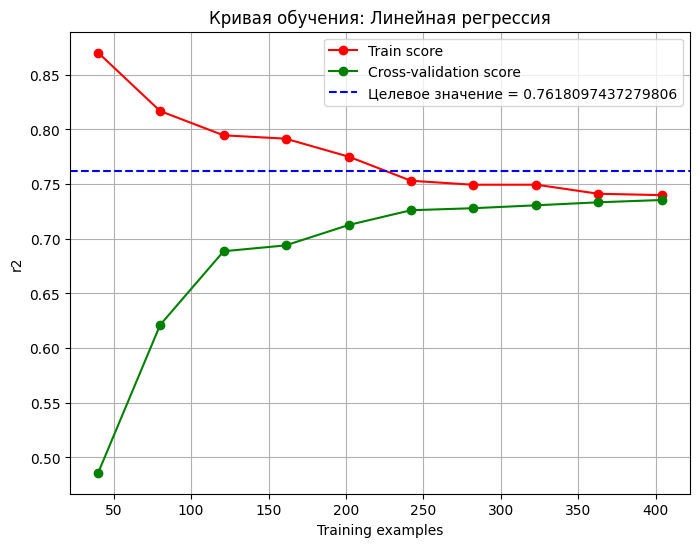

In [135]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred)

plot_learning_curve(model, "Кривая обучения: Линейная регрессия", X, y, cv=cv, baseline=baseline_r2)
#plot_learning_curve(DecisionTreeRegressor(), "Кривая обучения: Дерево решений", X, y, cv=cv, baseline=0.8)

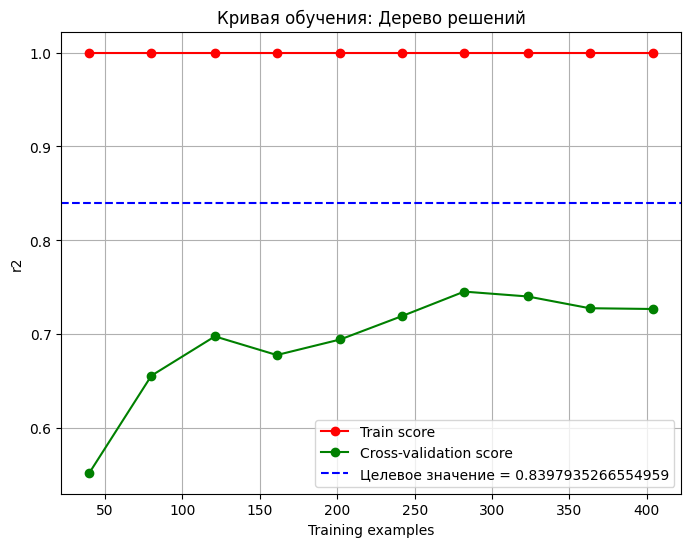

In [136]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred)

plot_learning_curve(model, "Кривая обучения: Дерево решений", X, y, cv=cv, baseline=baseline_r2)

Обучающая кривая (Train Score ≈ 1.0):
- Это говорит о переобучении: модель идеально запомнила обучающие данные.
- Признак: сильно завышенная метрика на обучении и низкая/нестабильная на тесте.

Decision Tree без ограничения глубины демонстрирует явное переобучение.

### Кривая обучения относительно ошибки

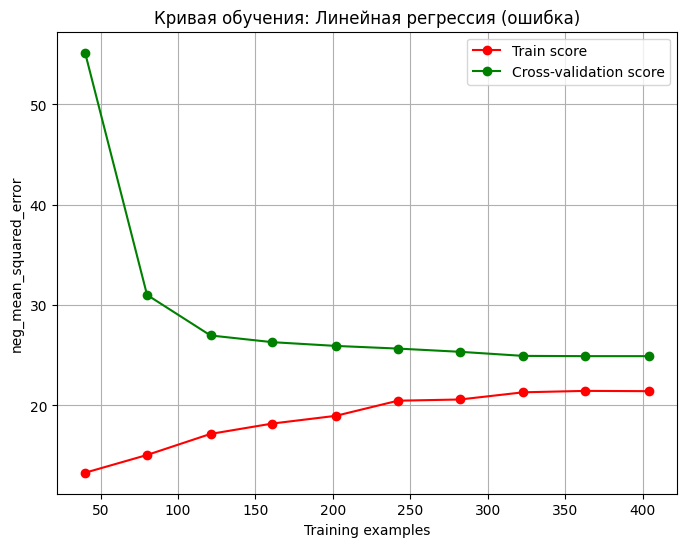

In [137]:
plot_learning_curve(LinearRegression(), "Кривая обучения: Линейная регрессия (ошибка)", X, y, cv=cv, scoring='neg_mean_squared_error')

## Задание 2

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [139]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

metrics = []
coefs = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics.append({
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

    # Сохраняем коэффициенты как Series с названиями признаков
    coefs[name] = pd.Series(model.coef_, index=X.columns)


metrics_df = pd.DataFrame(metrics)

In [140]:
print("Сравнение моделей по метрикам:")
print(metrics_df)

Сравнение моделей по метрикам:
        Model        R²        MSE       MAE
0      Linear  0.675736  35.552744  3.805211
1       Ridge  0.671646  36.001232  3.769240
2       Lasso  0.650222  38.350169  3.838243
3  ElasticNet  0.651081  38.255977  3.874625


- Линейная регрессия — показывает лучшие метрики, но может переобучаться, особенно при наличии мультиколлинеарности.
- Ridge — немного проигрывает по точности, но может быть более стабильной и устойчивой к шуму.
- Lasso — делает хуже по метрикам, но её главное преимущество — отбор признаков: она зануляет коэффициенты малозначимых признаков.

In [141]:
coefficients_df = pd.DataFrame(coefs).reset_index().rename(columns={'index': 'Feature'})

print("\nКоэффициенты моделей:")
print(coefficients_df)


Коэффициенты моделей:
    Feature     Linear     Ridge     Lasso  ElasticNet
0      CRIM  -0.072147 -0.067277 -0.061250   -0.064677
1        ZN   0.051367  0.052062  0.052866    0.055915
2     INDUS   0.074932  0.042595  0.006460    0.003779
3      CHAS   1.729967  1.534720  0.000000    0.405675
4       NOX -16.837131 -9.315189 -0.000000   -0.014745
5        RM   3.734711  3.811884  3.689016    3.210745
6       AGE  -0.003743 -0.010062 -0.012973   -0.011328
7       DIS  -1.307657 -1.193260 -1.009043   -1.024665
8       RAD   0.288178  0.275806  0.263401    0.276693
9       TAX  -0.014323 -0.015113 -0.016308   -0.016693
10  PTRATIO  -0.889731 -0.814917 -0.732114   -0.741331
11        B   0.010546  0.011032  0.011629    0.011304
12    LSTAT  -0.505230 -0.512270 -0.539085   -0.569601


Самые устойчивые признаки по всем моделям:
- RM — положительное влияние на цену (больше комнат — выше цена).
- LSTAT — отрицательное влияние (чем больше бедного населения, тем ниже цена).

Lasso и ElasticNet зануляют или значительно уменьшают коэффициенты некоторых признаков, таких как NOX, что указывает на их меньшую важность в модели или мультиколлинеарность с другими признаками.

CHAS в Lasso и ElasticNet значительно уменьшается по сравнению с Linear и Ridge, что говорит о том, что эти модели пытаются снизить влияние признаков, которые могут быть менее важными.

Результат ElasticNet: Величины коэффициентов находятся между результатами Ridge и Lasso, что соответствует его концепции сочетания обеих регуляризаций.

Выводы:
- Модели с регуляризацией (Ridge, Lasso и ElasticNet) показывают схожие результаты для некоторых признаков, но Lasso и ElasticNet склонны уменьшать веса менее значимых признаков или даже занулять их, что важно для отбора признаков.

- Ridge имеет более «мягкое» влияние на признаки и не уменьшает веса так сильно, как Lasso, что может помочь в случаях, где все признаки имеют некоторое значение.

- ElasticNet предлагает баланс между Ridge и Lasso, эффективно комбинируя их преимущества, однако для твоих данных это не приводит к заметным улучшениям в метриках.

LSTAT, RM — самые важные признаки для предсказания цены.